# Bone age using RadioGraphs

This notebook is developed to run Inception-v4 Nerural Network on hand Radiographs for bone age predictions.

The code involves:
<!-- - setup of `Weights and Biases` library to track training.
- Overfitting the model on single batch (32) of images
- Usage of `Weights and Biases` Sweeps
- Save models related to a sweep and then load them -->

This notebook also has a Tensorflow Function API practice section at the end

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.metrics import mean_absolute_error
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import cv2

import wandb
from wandb.keras import WandbCallback

#library required for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

from models import Inception, SmallCNN, BaselineCnn
from utils import create_dataset_from_file

pd.set_option('display.max_colwidth', None)
import visualkeras

2023-02-12 18:31:51.752426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 18:31:51.999179: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-12 18:31:52.005029: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2023-02-12 18:31:52.005046: I tensorflow/compiler/xla/stream_executor/cuda

In [3]:
IMG_SIZE = 256
img_size = IMG_SIZE

In [4]:
# machine = "remote_system"
machine = "local"
# loading Data
    
### Set here the localtion of the data folder of your google drive
if machine == "remote_system":
    train_dir = "/server0/0/2022/mtirmizi/Documents/bone_data/Bone Age Training Set/"
    validation_dir = "/server0/0/2022/mtirmizi/Documents/bone_data/Bone Age Validation Set/"
    test_dir = "/server0/0/2022/mtirmizi/Documents/bone_data/Bone Age Test Set/"
else:
    train_dir = "/home/teemo/Documents/bone_data/Bone Age Training Set/"
    validation_dir = "/home/teemo/Documents/bone_data/Bone Age Validation Set/"
    test_dir = "/home/teemo/Documents/bone_data/Bone Age Test Set/"


### Train Data
train_image_dir = os.path.join( train_dir, "boneage-training-dataset")
train_df = pd.read_csv( os.path.join(train_dir,"train.csv") )

### Validation Data
validation_image_dir = os.path.join( validation_dir, "boneage-validation-dataset")
valid_df = pd.read_csv( os.path.join(validation_dir,"Validation Dataset.csv") )

### Test Data
test_image_dir = os.path.join(test_dir, "boneage-testing-dataset")
test_df = pd.read_excel(  os.path.join(test_dir, "test.xlsx"))

# Preprocess Train Dataset
train_df["male"] = train_df["male"].astype(int)

# Preprocess Validation Dataset
valid_df = valid_df.rename(columns={'Bone Age (months)': 'boneage', 'Image ID': 'id'})
valid_df["male"] = valid_df["male"].astype(int)

# Preprocess Test Dataset
test_df = test_df.rename(columns={'Ground truth bone age (months)': 'boneage', 'Case ID': 'id'})
test_df["male"] = test_df['Sex'].replace(['M', 'F'], [1, 0])
test_df = test_df.drop(columns=["Sex"])


# Appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x) + '.png')
valid_df['id'] = valid_df['id'].apply(lambda x: str(x) + '.png')
test_df['id'] = test_df['id'].apply(lambda x: str(x) + '.png') 

# Create Image paths. Will be needed in tensorflow Dataset API
train_df['img_path'] = train_df['id'].apply(lambda x: os.path.join(train_image_dir, str(x)) )
valid_df['img_path'] = valid_df['id'].apply(lambda x: os.path.join(validation_image_dir, str(x)) )
test_df['img_path'] = test_df['id'].apply(lambda x: os.path.join(test_image_dir, str(x)) )

#mean age is
mean_bone_age = train_df['boneage'].mean()

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df.loc[:, 'bone_age_z'] = (train_df['boneage'] - mean_bone_age) / std_bone_age

# Similarly z score for Validation & testing data
valid_df.loc[:, "bone_age_z"] = (valid_df["boneage"] - mean_bone_age) / std_bone_age
test_df.loc[:, 'bone_age_z'] = (test_df['boneage'] - mean_bone_age) / std_bone_age

train_df = train_df[:64]

train_dataset = create_dataset_from_file(train_df["img_path"], train_df["male"].to_numpy().reshape(-1, 1), train_df["bone_age_z"], use_gender=False, batch_size=32, img_size=img_size)
valid_dataset = create_dataset_from_file(valid_df["img_path"], valid_df["male"].to_numpy().reshape(-1, 1), valid_df["bone_age_z"], use_gender=False, batch_size=32, img_size=img_size)
test_dataset = create_dataset_from_file(test_df["img_path"], test_df["male"].to_numpy().reshape(-1, 1), test_df["bone_age_z"], use_gender=False, batch_size=32, img_size=img_size)

train_dataset_wg = create_dataset_from_file(train_df["img_path"], train_df["male"].to_numpy().reshape(-1, 1), train_df["bone_age_z"], use_gender=True, batch_size=32, img_size=img_size)
valid_dataset_wg = create_dataset_from_file(valid_df["img_path"], valid_df["male"].to_numpy().reshape(-1, 1), valid_df["bone_age_z"], use_gender=True, batch_size=32, img_size=img_size)
test_dataset_wg = create_dataset_from_file(test_df["img_path"], test_df["male"].to_numpy().reshape(-1, 1), test_df["bone_age_z"], use_gender=True, batch_size=32, img_size=img_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-12 18:32:12.231261: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/teemo/anaconda3/envs/ds/lib/python3.10/site-packages/cv2/../../lib64:/app/lib
2023-02-12 18:32:12.231285: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-12 18:32:12.231301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2023-02-12 18:32:12.231580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild Ten

In [4]:
#### Use a smaller subset of the training data
train_df = train_df[:64]
# valid_df = valid_df[:64]

In [ ]:
### Statistics about the data
print( f"Images in the training set: {len(train_df)}" )
print( f'Images in the validation set: {len(valid_df)}')
print( f"Images in the test set: {len(test_df)}" )

Images in the training set: 64
Images in the validation set: 64
Images in the test set: 200


In [5]:
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

def round_mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    x_p = np.round(std_bone_age * x_p + mean_bone_age)
    y_p = np.round(std_bone_age * y_p + mean_bone_age)
    return mean_absolute_error(x_p, y_p) 

## Load Model

In [9]:
# import wandb
# run = wandb.init()
# artifact = run.use_artifact('hda-project/hda-final/model-Incenptionv4-v2-wg:v12', type='model')
# artifact_dir = artifact.download()

import wandb
run = wandb.init()
artifact = run.use_artifact('hda-project/hda-final/model-CNN-DA-v2-g-True:v31', type='model')
artifact_dir = artifact.download()

# artifact_dir = './artifacts/model-Incenptionv4-v2-wg:v26'
# Load the saved model
model = tf.keras.models.load_model(artifact_dir, custom_objects={"mae_in_months": mae_in_months})
# model.summary()

wandb: Downloading large artifact model-CNN-DA-v2-g-True:v31, 53.58MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:2.5


## Test Model

In [11]:
def tf_dataset_calculate_mae_in_months(model=None, tf_dataset=None, do_print=True):
    """
    Allows to unpack all the values from tf_dataset, as in default it gives only batches and to calculate
    mae (or MAD) on a dataset we need all the values.
    """
    def round_mae_in_months(x_p, y_p):
        '''function to return mae in months'''
        x_p = np.round(std_bone_age * x_p + mean_bone_age)
        y_p = np.round(std_bone_age * y_p + mean_bone_age)
        return mean_absolute_error(x_p, y_p) 
    pred_y = np.array([])
    test_y = np.array([])
    for xray_batch in tf_dataset:
        # In xray_batch is a tuple, 1st element is features, 2nd element is the label or target
        yhat = model.predict(xray_batch[0]).flatten()
        pred_y = np.append(pred_y, yhat)
        y = xray_batch[1].numpy()
        test_y = np.append(test_y, y)
    mae = mae_in_months(pred_y, test_y)
    rounded_mae = round_mae_in_months(pred_y, test_y)
    if do_print:
        print(f"Mae: {mae}")
        print(f"Rounded MAE or MAD: {rounded_mae}")
    #     break
    # print(f"pred_y: {len(pred_y)}")
    # print(f"test_y: {len(test_y)}")
    return mae.numpy(), rounded_mae.numpy()

tf_dataset_calculate_mae_in_months(model, test_dataset_wg)

1/1 [==============================] - 0s 82ms/step
Mae: 17.704637114824013
Rounded MAE or MAD: 17.765


(17.704637114824013, 17.765)

In [31]:
for (test_X, gender), test_Y in train_dataset_wg.take(1):
    # print(test_Y)
    test_months = mean_bone_age + std_bone_age * (test_Y)
    test_months = np.round(test_months)
    print(test_months)
    break

[180.  12.  94. 120.  82. 138. 150. 156.  36. 138. 126. 138. 156. 180.
 132.  57. 120. 188.   4.  36. 132.  24.  60. 159. 120. 106.  30. 126.
 149.  33. 156.  78.]


1/1 [==============================] - 3s 3s/step
5661.0  MSE months
18
15
16
28
17


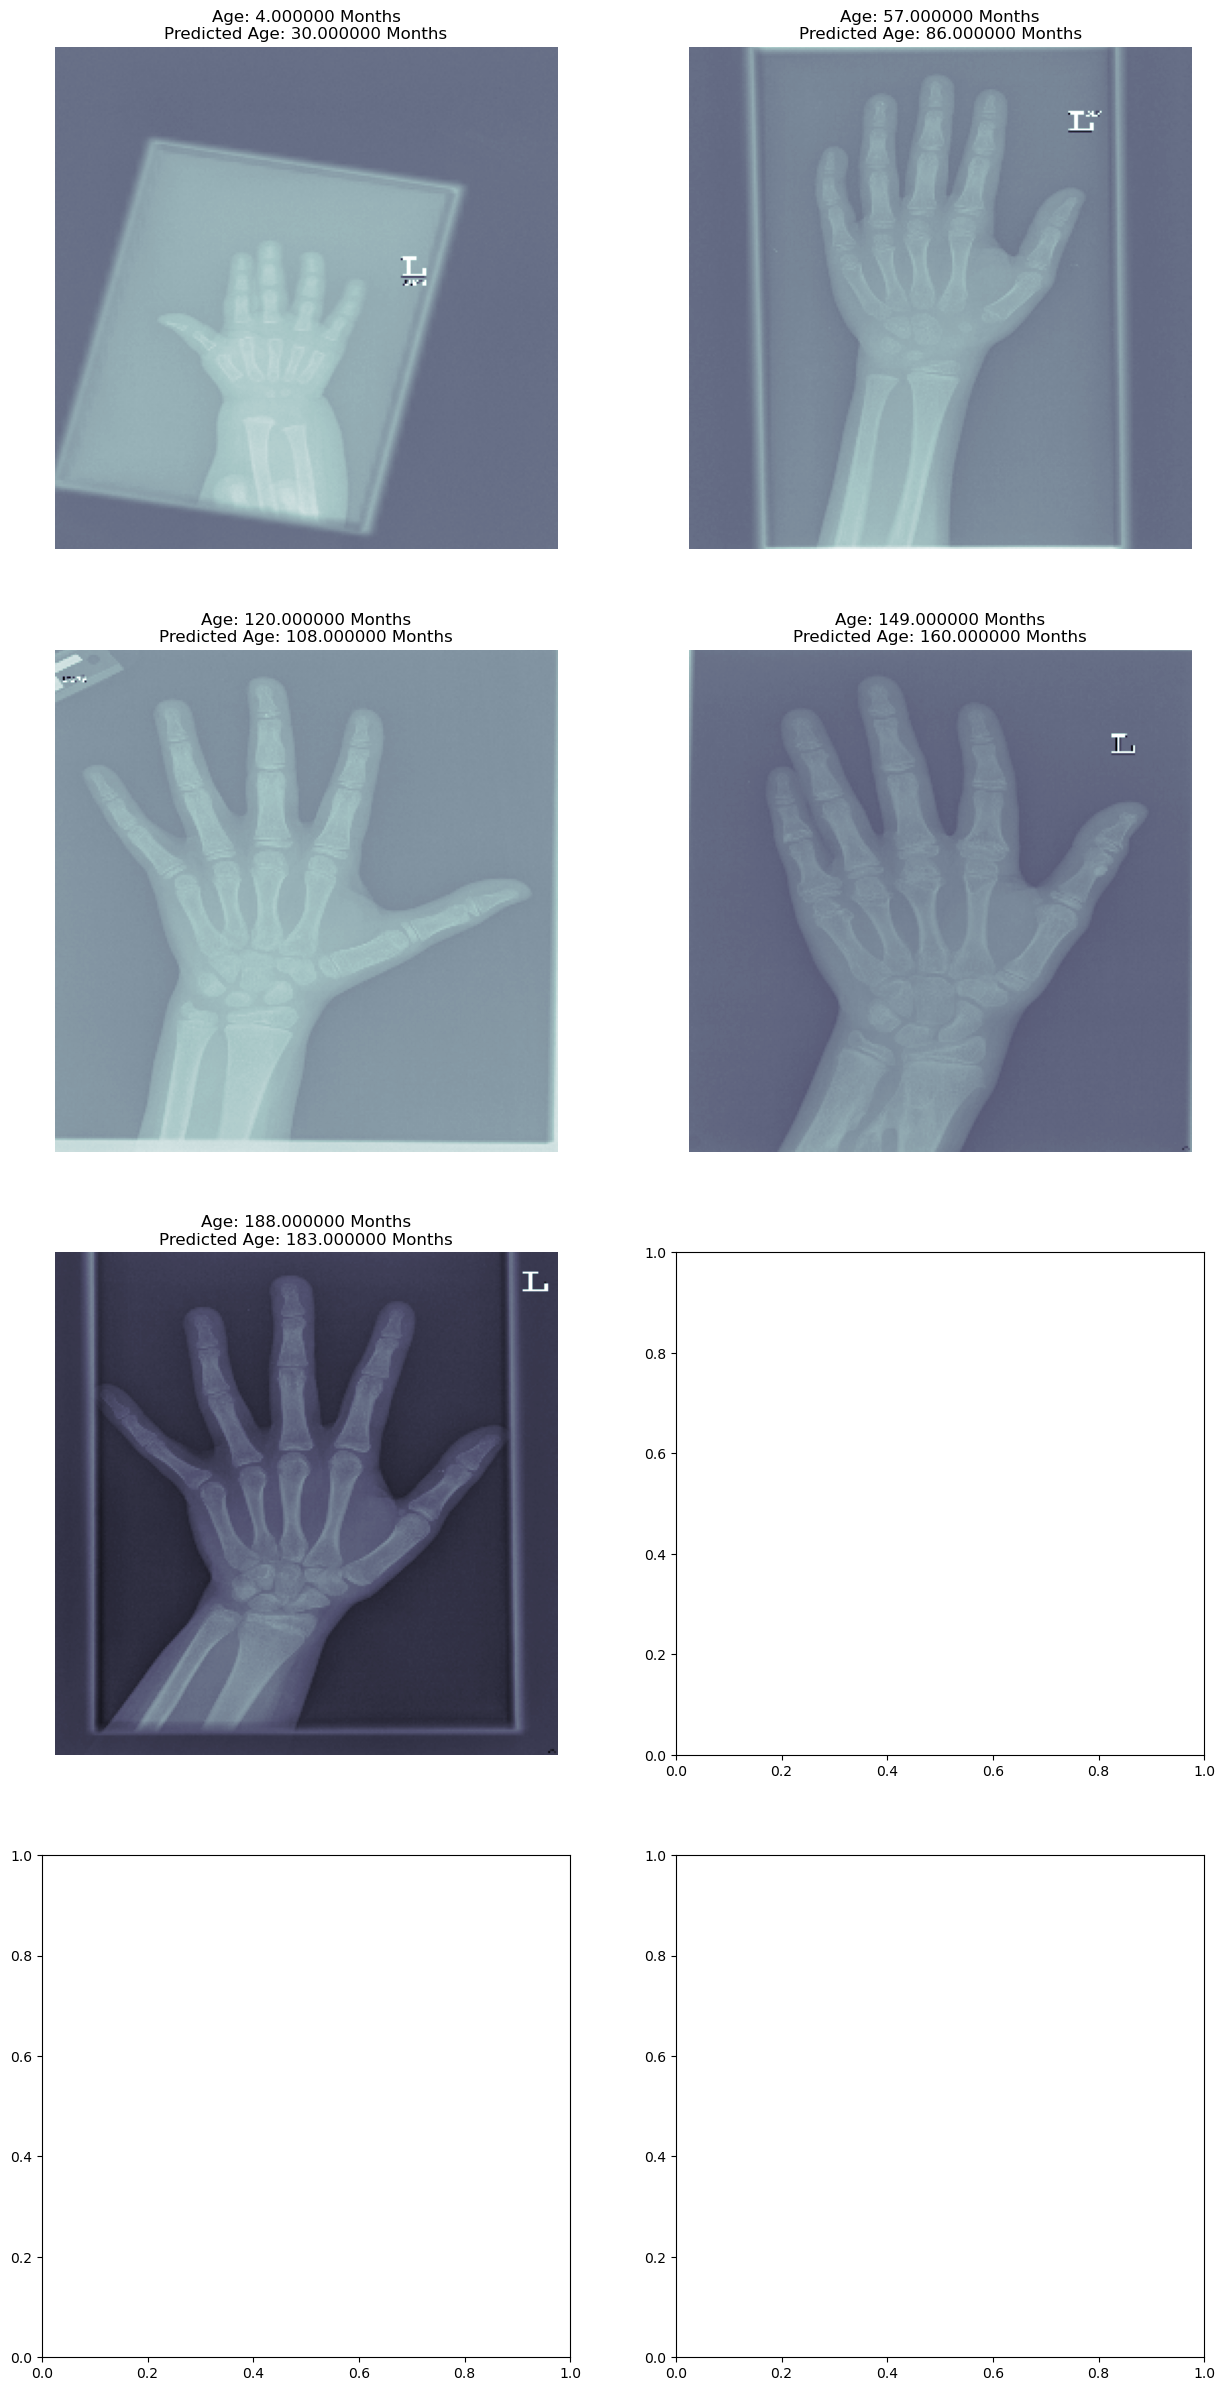

In [38]:
# Get predictions from the model
# test_X, test_Y = next(train_generator)
for (test_X, gender), test_Y in train_dataset_wg.take(1):
    mean_age_error = 0
    pred = mean_bone_age + std_bone_age * (model.predict( [test_X, gender], batch_size = 32, verbose = True))
    pred = np.round(pred)
    test_months = mean_bone_age + std_bone_age * (test_Y)
    test_months = np.round(test_months)

    print( np.sum( np.square( (pred.flatten() - test_months ) ) ), " MSE months" )  # 130.5
    ord_ind = np.argsort(test_Y)
    ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 5).astype(int)] # take 8 evenly spaced ones
    fig, axs = plt.subplots(4, 2, figsize = (15, 30))
    for (ind, ax) in zip(ord_ind, axs.flatten()):
        print(ind)
        ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
        # ax.set_title('Age: %fY\nPredicted Age: %f Y' % (test_months[ind]/12.0, pred[ind]/12.0))
        ax.set_title('Age: %f Months\nPredicted Age: %f Months' % (test_months[ind], pred[ind]))
        ax.axis('off')
        # mean_age_error += (test_months + pred)
    # fig.savefig('trained_image_predictions.png', dpi = 300)

Text(0, 0.5, 'Predicted Age (Months)')

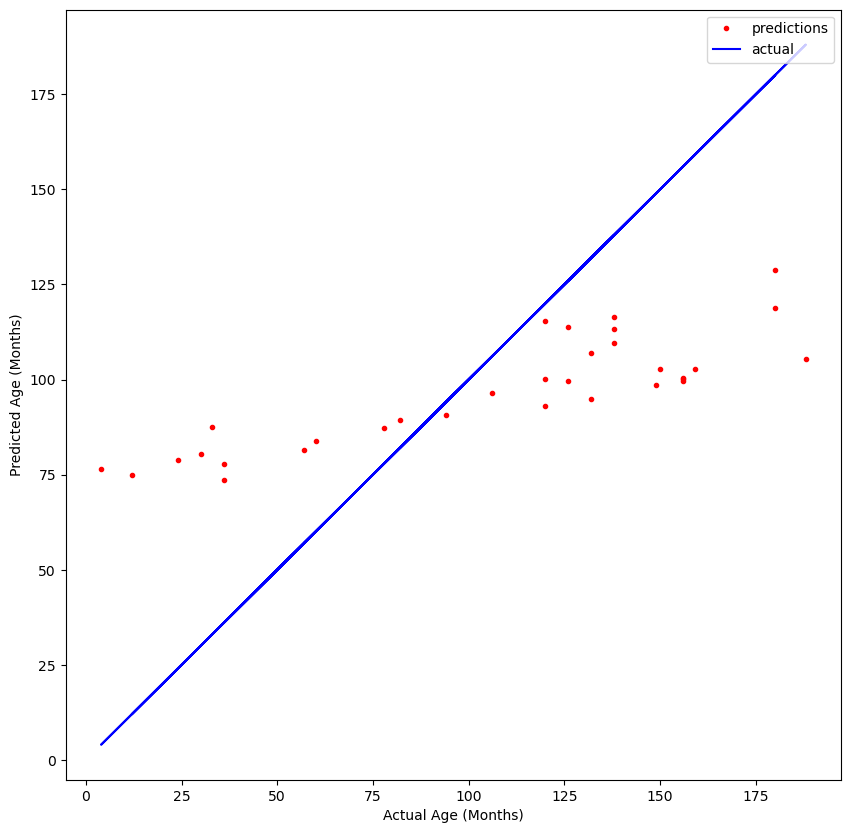

In [154]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(test_months, pred, 'r.', label = 'predictions')
ax.plot(test_months, test_months, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

# Practice ---------- Functional API

In [13]:
img_inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Dense(64, activation='relu')(img_inputs)
x = tf.keras.layers.Dense(32, activation='relu')(x)
model = model = tf.keras.Model(inputs=img_inputs, outputs=x, name="mnist_model")
model.summary()
# tf.keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 dense (Dense)               (None, 32, 32, 64)        256       
                                                                 
 dense_1 (Dense)             (None, 32, 32, 32)        2080      
                                                                 
Total params: 2,336
Trainable params: 2,336
Non-trainable params: 0
_________________________________________________________________


2023-01-11 19:57:22.071912: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/teemo/anaconda3/envs/ds/lib/python3.10/site-packages/cv2/../../lib64:/app/lib
2023-01-11 19:57:22.071942: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-11 19:57:22.071967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2023-01-11 19:57:22.072336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild Ten

#### Now creating a base line CNN model with Functional API

In [14]:
import cv2

def load_image(img_name):
    """
    Returns numpy.ndarray (img_size, img_size, 3)
    """
    if isinstance(img_name, bytes):
        img_name = img_name.decode()
    img = cv2.imread(img_name, cv2.IMREAD_COLOR)
    # Want numpy array to have "float32" and not "uint8" 
    img = np.array( cv2.resize(img, (img_size, img_size)), dtype="float32" )

    return img


def normalize_img(image):
    return tf.cast(image, tf.float32) / 255.0


# Create a Dataset object
train_image_data = tf.data.Dataset.from_tensor_slices( train_df["img_path"]  )

# allows to injest tensor op file_paths by a python function
py_func = lambda file_name: (tf.numpy_function(load_image, [file_name], tf.float32))
train_image_data = train_image_data.map(py_func, num_parallel_calls=os.cpu_count())

# Normalize the images, meaning bring their values range between 0 and 1
train_image_data = train_image_data.map(normalize_img, num_parallel_calls=os.cpu_count())



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
# train_image_data = train_image_data.batch(1)
# next(iter( train_image_data )).shape
# next( iter( train_image_data ) )

In [147]:
train_dataset = create_dataset_from_file(train_df["img_path"], train_df["male"].to_numpy().reshape(-1, 1), train_df["bone_age_z"], use_gender=True, batch_size=32)
valid_dataset = create_dataset_from_file(valid_df["img_path"], valid_df["male"].to_numpy().reshape(-1, 1), valid_df["bone_age_z"], use_gender=True, batch_size=32)
test_dataset = create_dataset_from_file(test_df["img_path"], test_df["male"].to_numpy().reshape(-1, 1), test_df["bone_age_z"], use_gender=True, batch_size=32)

In [89]:
for a, c in train_dataset.take(2):
    print(a.shape)
    print(b.shape)
    print(c.shape)

(32, 256, 256, 3)
(32,)
(32,)
(32, 256, 256, 3)
(32,)
(32,)


In [45]:
### Training Data
random_img = np.random.randint(255, size=(32, 256, 256, 3)).astype("float32") / 255
target_age = np.random.random(size=(32, 1))

print( f"Shape of the temp images: {random_img.shape}")
print(f"Shpae of the target age: {target_age.shape}")

def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

Shape of the temp images: (32, 256, 256, 3)
Shpae of the target age: (32, 1)


In [148]:
img_inputs = tf.keras.Input(shape=(256, 256, 3), name="Image")
input_gender = tf.keras.Input(shape=(1), name="Gender")

# CNN
x = tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding="same", activation=None)(img_inputs)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)

x = tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding="same", activation=None)(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)

x = tf.keras.layers.Flatten()(x)

# 
m = tf.keras.layers.Dense(32, activation='relu')(input_gender)

# Concatenate CNN and Gender-Dense
xm = tf.keras.layers.concatenate([x, m], name="concat-layer")


xm = tf.keras.layers.Dense(64, activation='relu')(xm)
xm = tf.keras.layers.Dense(16, activation='relu')(xm)


age_output = tf.keras.layers.Dense(1, activation = 'linear')(xm)

model = model = tf.keras.Model(inputs=[img_inputs, input_gender], outputs=age_output, name="Age_prediction_model")
model.summary()



Model: "Age_prediction_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 256, 256, 8)  224         ['Image[0][0]']                  
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 8)  32         ['conv2d_36[0][0]']              
 ormalization)                                                                                    
                                                                               

In [ ]:

# model.compile(loss ='mse', optimizer= tf.keras.optimizers.Adam( 0.001 ), metrics=["mse"])
model.compile(loss ='mse', optimizer= tf.keras.optimizers.Adam( 0.001 ), metrics = [mae_in_months])
# history = model.fit(random_img, target_age, batch_size=32, epochs=1000, validation_data=)
model.fit(train_dataset, batch_size=32, epochs=160)



In [9]:
title_data = np.random.randint(10000, size=(1280, 10))
body_data = np.random.randint(10000,  size=(1280, 100))
tags_data = np.random.randint(2,      size=(1280, 4)).astype("float32")


In [13]:
print(title_data.shape)
print(body_data.shape)
print(tags_data.shape)


(1280, 10)
(1280, 100)
(1280, 4)


In [6]:
type(model)

keras.engine.functional.Functional

--------------------- End practice -------------------